# Normalizzazione dati inquinamento #
In questo notebook andrò a descrivere le attività realizzate per quanto riguarda la normalizzazione dei dati sugli inquinanti atmosferici relativamente alle variabili meteorologiche.

## Introduzione a random forest ##
Random forest è un algoritmo di machine learning d'insieme, adatto a risolvere sia problemi di classificazione che di regressione. Visto che nel nostro caso quello che vogliamo stimare è una quantità, nello specifico la concentrazione di un inquinante, noi useremo la variante regressiva. Concettualmente comunque il metodo è praticamente lo stesso per entrambi i problemi, fatto salvo per alcuni dettagli minori.  
Random forest, applicando alcune tencniche, riesce a risolvere il problema dell'overfitting caratteristico degli alberi di decisione. Si parla di overfitting quando, dopo aver creato un modello secondo le specifiche dell'algoritmo utilizzato, se ne ottiene uno che ha buone performance sui dati usati per costruirlo ma poi risulta poco preciso quando viene messo alla prova su dati mai visti. Chiaramente questa è una situazione che si vuole evitare, poichè l'obbiettivo è quello di arrivare ad ottenere un modello le cui previsioni siano sufficentemente precise indipendentemente dai dati che gli vengono passati in input.  
Random forest si basa sull'utilizzo di molti alberi di decisione per fare le previsioni, così da ridurre la varianza del modello.

### Definizione metodo ###
Il nostro obbiettivo è quello di riuscire a stimare un valore, nel nostro caso la concentrazione di un inquinante, partendo da un set di valori per un numero di variabili dette predittrici o features.  
È quindi chiaro che per poter fare questo tipo di lavoro sia necessario che i valori della variabile di output (la variabile che vogliamo predirre) debbano essere in qualche modo in relazione con quelli delle variabili di input (features).
Se chiamiamo $Y$ la variabile che rappresenta la concentrazione dell'inquinante di interesse ed $X$ la variabile che rappresenta i valori delle variabili di input, possiamo pensare di definire questa relazione in questo modo:
<center>$Y = f(X)$</center>
Chiaramente per noi la vera forma di $f$ è sconosciuta, poichè non possiamo conoscere tutti i fattori e le relazioni che influenzano i valori di $Y$. Possiamo però, attraverso la costruzione di un modello, creare una funzione $\hat{f}$ che sia una stima di tale funzione. La nostra definizione può quindi essere cambiata in:
<center>$\hat{Y} = \hat{f}(X)$</center>
dove $\hat{Y}$ è la variabile che rappresenta le predizioni fatte dal nostro modello (e che chiaramente vorremmo che sia il più vicino possibile ai reali valori di $Y$).

Come già accennato il modello costruito da random forest si basa sull'uso di molti alberi di decisione. Per diminuire la varianza del modello ottenuto, senza però aumentare la distorsione, viene applicata una tecnica detta bagging. Questo significa che mentre le previsioni di un singolo albero sono molto sensibili al "rumore" presente nei dati utilizzati per la sua costruzione, la media di molti alberi invece non lo è, a patto che questi alberi siano decorrelati. Il bagging serve proprio per riuscire ad ottenere questa decorrelazione tra i vari alberi che comporranno la foresta del nostro modello.
Fare bagging significa che ogni albero verrà creato partendo da un campione estratto casualmente e con ripetizione dei dati su cui vogliamo costruire il modello. Questo significa quindi che ogni albero verrà creato sulla base di un insieme di dati diverso da quello usato per creare gli altri, ottenendo quindi la decorrelazione.

## Esempio di applicazione ##
Di seguito verrà illustrato un esempio dell'applicazione di questo metodo per provare ad ottenere la normalizzazione dei dati di un inquinante rispettivamente alle condizioni metereologiche.

Nel nostro esempio la variabile $Y$ saranno le concentrazioni degli NOx, e le variabili predittrici ($X$) saranno data, precipitazioni, temperatura, direzione e velocità del vento, umidità, giorno della settimana e giorno dell'anno. 

Chiaramente la prima cosa da fare è scegliere una stazione su cui vogliamo basare la nostra analisi d'esempio.
La stazione scelta è quella di Milano Via Zavattari, poichè possiede sensori sia per i principali inquinanti che per le variabili metereologiche che ci interessano.

Innanzitutto eseguiamo l'import dei package che saranno impiegati.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import info_stazioni as info
import data_preparation as data_prep
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import numpy as np
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

Il primo passaggio da eseguire è quello di prepararsi una tabella, a risoluzione giornaliera, in cui per ogni data saranno contenuti i valori delle variabili del nostro modello.
Questo è possibile tramite l'uso della funzione prepare_data, contenuta nel file data_preparation.py .
La funzione accetta come parametri:
- Id del sensore per l'inquinante
- Id del sensore per la temperatura
- Id del sensore per le precipitazioni
- Id del sensore per la direzione del vento
- Id del sensore per la velocità del vento
- Id del sensore per l'umidità
- Unità temporale da usare per aggregare i dati ("d", "h", ..)

Dati questi parametri la funzione provvederà a creare la tabella recuperando i dati dei vari sensori dai file CSV precedentemente generati, filtrando le date per cui non si hanno valori validi per l'inquinante e riempiendo gli altri dati mancanti con la media dei valori di tale dato.

**I dati per le variabili metereologiche del '06-'08 purtroppo non risultano disponibili, in quanto l'archivio messo a disposizione da ARPA risulta danneggiato e non leggibile. Ho provato a contattare ARPA per chiedere se si potesse risolvere il problema ma attualmente non ho ricevuto risposta.  
Attualmente sto ancora valutando se considerare lo stesso buoni i dati per tale periodo oppure se scartarlo, che forse è più ragionevole.**

La funzione prepare_data ci restituisce già una tabella indicizzata per data. Noi però dobbiamo comunque aggiungere una colonna che la rappresenti per due motivi: il primo è che non è possibile costruire modelli basandosi su variabili di tipo 'datetime' (e quindi useremo il campo epoch), il secondo invece è perchè, per come è stato implementato l'algoritmo, non si può usare la colonna dell'indice come variabile da considerare nella creazione del modello.

In [2]:
data = data_prep.prepare_data(6372, 5920, 9341, 19006, 19005, 6185, "d")
#ricavo il campo epoch partendo dalla data contenuta nell'indice
data["epoch"] = data.index.astype("int64")
data

,inquinante,temperatura,precipitazioni,direzione_vento,velocita_vento,umidita,day_of_year,day_of_week,epoch
Data,,,,,,,,,
1980-09-18,488.133333,13.799717,0.085468,216.788013,1.243275,66.734669,262,3,338083200000000000
1980-09-19,761.312500,13.799717,0.085468,216.788013,1.243275,66.734669,263,4,338169600000000000
1980-09-20,414.704167,13.799717,0.085468,216.788013,1.243275,66.734669,264,5,338256000000000000
1980-09-21,474.891667,13.799717,0.085468,216.788013,1.243275,66.734669,265,6,338342400000000000
1980-09-22,483.570833,13.799717,0.085468,216.788013,1.243275,66.734669,266,0,338428800000000000
...,...,...,...,...,...,...,...,...,...
2016-12-27,125.750000,12.132639,0.000000,157.540972,1.619444,67.880303,362,1,1482796800000000000
2016-12-28,148.016667,7.166667,0.000000,229.563889,0.832639,54.708333,363,2,1482883200000000000
2016-12-29,87.808333,5.859028,0.000000,130.990278,1.540278,68.527778,364,3,1482969600000000000


Visto che le rilevazioni per le variabili metereologiche iniziano dopo gli anni 2000 filtriamo la tabella in modo che contenga solo osservazioni successive a tale data.

In [3]:
data = data[data.index >= '2000-01-01']
data

,inquinante,temperatura,precipitazioni,direzione_vento,velocita_vento,umidita,day_of_year,day_of_week,epoch
Data,,,,,,,,,
2000-01-01,447.433333,0.354167,0.085468,216.788013,1.243275,66.734669,1,5,946684800000000000
2000-01-02,346.137500,0.366667,0.085468,216.788013,1.243275,66.734669,2,6,946771200000000000
2000-01-03,549.454167,0.370833,0.085468,216.788013,1.243275,66.734669,3,0,946857600000000000
2000-01-04,673.245833,1.791667,0.085468,216.788013,1.243275,66.734669,4,1,946944000000000000
2000-01-05,819.020833,3.520833,0.085468,216.788013,1.243275,66.734669,5,2,947030400000000000
...,...,...,...,...,...,...,...,...,...
2016-12-27,125.750000,12.132639,0.000000,157.540972,1.619444,67.880303,362,1,1482796800000000000
2016-12-28,148.016667,7.166667,0.000000,229.563889,0.832639,54.708333,363,2,1482883200000000000
2016-12-29,87.808333,5.859028,0.000000,130.990278,1.540278,68.527778,364,3,1482969600000000000


Prima di iniziare dichiariamo una serie di funzioni che saranno utili nella valutazione del modello.
- rf_feat_importance serve per creare la tabella con l'importanza delle variabili predittrici 
- evaluate_training ci dà una serie di metriche per misurare le performance del nostro modello durante la fase di costruzione
- evaluate_testing ci dà una serie di metriche per misurare le performance del nostro modello sul test set (quindi su dati nuovi che non avevo mai visto prima)

I loro risultati saranno approfonditi successivamente.

In [4]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

def evaluate_training(model, x_train, y_train):
    y_pred_train = model.predict(x_train)
    mse = metrics.mean_squared_error(y_train, y_pred_train)
    print("Training:")
    print("MSE:", mse)
    print("RMSE:", np.sqrt(mse))
    print("OOB Score (R^2):", model.oob_score_)
    
def evaluate_testing(model, x_test, y_test):
    y_pred = model.predict(x_test)
    mse = metrics.mean_squared_error(y_test, y_pred)
    print("Testing:")
    print("MSE:", mse)
    print("RMSE:", np.sqrt(mse)) 
    print("R^2 for testing:", model.score(x_test, y_test))

## Creazione del modello ##
Ora che abbiamo a disposizione i nostri dati possiamo passare a creare il modello che poi andremo ad usare per ottenere i valori dell'inquinante normalizzati.

Come prima operazione è necessario estratte da questa tabella i valori della variabile da predirre (la nostra $X$) e i valori delle variabili predittrici ($Y$).
Queste due variabili vengono poi ulteriormente divise attraverso l'uso della funzione train_test_split. Questa funzione, contenuta nel package scikit-learn, dividerà x e y in due gruppi ciascuno, che chiameremo training set e test set, assegnando al training set l'80% delle osservazioni totali (come specificato dal parametro train_size).
Questa operazione è fatta in modo da avere una parte di dati che sarà usata per la costruzione del modello (il training set) e una che sarà usata per verificare le performance del modello (il test set).

In [5]:
y = data.inquinante
x = data.drop("inquinante", 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = .8, random_state = 123)

Ora che abbiamo diviso i nostri dati siamo finalmente pronti a creare il modello. L'algoritmo di random forest ha una serie di iperparametri settabili; inizialmente l'unico che andiamo a fissare è il numero di alberi da creare nella foresta, che per ora settiamo a 100. Il parametro oob_score serve per indicare di calcolare lo score del modello sui dati out of bag, mentre random_state serve per specificare il seed da usare per le operazioni casuali e, se settato, rendere quindi l'esperimento riproducibile.

**Cosa sono i dati out of bag?**  
Come descritto in precedenza ogni albero della foresta viene creato attrraverso l'applicazione del bagging, ovvero estrando un subset casuale dai dati di partenza. In questo subset non è assolutamente detto che siano contenute tutte le osservazioni presenti nei dati originali (anzi, è quello che vorremmo evitare per decorrelare i vari alberi) di cui in media non viengono usate il 30% delle osservazioni.  
Ogni albero quindi avrà una parte di dati che non saranno stati usati nella sua creazione e che possono perciò essere utilizzati per testare le sue performance: questi dati vengono detti Out Of Bag. 
Più avanti descriverò più approfonditamente in che modo si fa questa valutazione.

Andiamo quindi a creare il nostro modello passandogli i dati contenuti nel training set. Una volta create useremo le due funzioni dichiarate in precedenza per valutare il modello durante la fase di training e quella di testing.

In [6]:
#max_depth, max_features
model = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=123)
model.fit(x_train, y_train)

evaluate_training(model, x_train, y_train)
evaluate_testing(model, x_test, y_test)

Training:
MSE: 664.2315578677553
RMSE: 25.77269015581717
OOB Score (R^2): 0.6984649491734505
Testing:
MSE: 5076.298448746311
RMSE: 71.24814698465013
R^2 for testing: 0.6999967947469763


Le metriche usate per la valutazione del modello, sia nella fase di training (costruzione) che in quella di testing (valutazione delle sue performance) sono le seguenti:
1. **MSE: Mean Squared Error**  
    Chiamiamo $Y_i$ il valore della variabile $Y$ per l'i-esima osservazione e $\hat{Y_i}$ il valore della predizione fatta dal nostro modello per l'i-esima osservazione. Allora, se $n$ è il numero totale delle osservazioni presenti nei nostri dati      
    <center>$MSE = \frac{1}{n}\sum_{i=1}^{n} (Y_i - \hat{Y_i})^2$</center>
    
    Chiaramente più il nostro modello sarà preciso e più questo valore si avvicinerà allo 0.
2. **RMSE: Root Mean Squared Error** 
    <center>$RMSE = \sqrt{MSE}$</center>
    
    Non è altro che la radice quadrate del MSE. Questo indice ha il vantaggio di essere espresso con la stessa unità di misura della variabile da predirre
3. **OOB Score / $R^2$** 
    Nel contesto dei metodi statistici il cui obbiettivo è fare delle previsioni, il coefficiente $R^2$ ci indica quanto bene il nostro modello rappresenta i dati osservati, basandosi sulla proporzione di varianza spiegata dal modello.  
    Il coefficiente viene così calcolato:  
    <center>$R^2 = \frac{\sum_{i=1}^{n} (Y_i - \hat{Y_i})^2}{\sum_{i=1}^{n} (Y_i - \overline{Y_i})^2}$</center>  
    
    Dove $\overline{Y_i}$ è la media dei valori di Y.
    Per quanto riguarda l'OOB Score il procedimento ottenuto per calcolarlo è lo stesso, ma al posto che usare l'intera foresta per fare una previsione, per ogni osservazione vengono fatte fare le previsioni solo a quegli alberi per cui tale osservazione risulta OOB. Così facendo si può quindi ottenere una stima di quello che sarà il test error del nostro modello. 
    L'indice normalmente assume valori tra 0 e 1.
    
Il valore del coefficiente $R^2$ per il modello appena costruito è di 0.7, che è un valore accettabile. Chiaramente poi si potrà lavorare per capire se si può migliorare ulteriormente.

## Importanza delle variabili ##
Uno dei vantaggi dati dall'applicazione di random forest è quello di poter analizzare l'importanza delle variabili usate per le nostre predizioni, in modo da capire quali siano le più influenti.
Le variabili più importanti sono chiaramente quelle che influiscono maggiormente sulla variabile da predirre, ovvero quelle che al cambiare del loro valore fanno cambiare maggiormente anche il risultato della previsione.

In [7]:
rf_feat_importance(model, x_train)

,cols,imp
5,day_of_year,0.341430
0,temperatura,0.265294
7,epoch,0.237087
6,day_of_week,0.063919
4,umidita,0.050034
3,velocita_vento,0.020377
1,precipitazioni,0.014018
2,direzione_vento,0.007840


Come si può vedere il giorno dell'anno risulta la variabile più influente, cosa che non risulta per niente sorprendente se consideriamo la stagionalità degli NOx. Le altre variabili importanti sono la temperatura e la data, a significare che il passare del tempo ha influito molto sui valori registrati. Anche questa osservazione non dovrebbe sorprenderci, visto che è noto come gli inquinanti abbiano tutti dei trend in calo nel corso degli ultimi anni.  
Le restanti variabili sembrano avere un'importanza piuttosto limitata.

## Partial dependence plots ##
Un'altra analisi che si può fare sul modello e sulle variabili usate per effettuare le previsioni è quella tramite l'uso dei partial dependence plots. Viene generato un grafico per ogni variabile predittrice usata nel nostro modello ed ognuno sarà la rappresentazione di come cambiano i valori di $X$ al cambiare di tale variabile predittrice se si lasciano le altre fissate al loro valore medio.

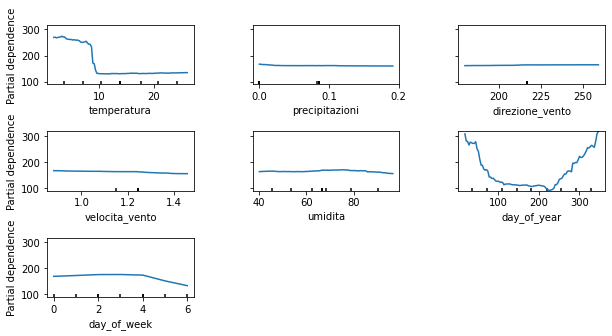

In [33]:
#partial dependence plots
plt.rcParams['figure.figsize'] = [10, 5]

plot_partial_dependence(model, x_train, x_train.columns.drop("epoch"), )
fig = plt.gcf()
fig.subplots_adjust(wspace=0.4, hspace=0.8)

Osservando i grafici è facile capire come cambi il valore della concentrazione di inquinante al variare delle diverse variabili. Per esempio è molto evidente come i valori più alti siano registrati nella stagione invernale o, comunque, quando si registrano temperature al di sotto dei 10 gradi.

## Normalizzazione dei dati ##
Come avevo già descritto precedentemente il processo per ottenere il valore della concentrazione di un inquinante per una data consiste nel far fare al nostro modello 1000 previsioni per tale data, ma con tutte le altre variabili che cambiano casualmente di previsione in previsione, calcolandone infine la media.  
La funzione normalize_timeseries() applica questo processo a tutte le date presenti nel dataset iniziale, in modo da poter ottenere la timeseries normalizzata per l'inquinante di interesse.

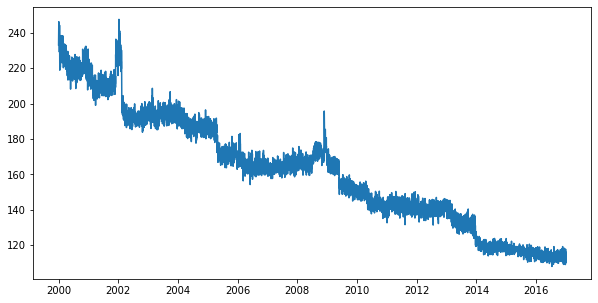

In [9]:
def normalize_timeseries():
    #per 1000 volte...
    # 1. shufflo tutte le righe di tot tranne per la data
    # 2. faccio fare le prediction 
    # 3. appendo data e prediction a un altro df
    #--
    #groupby.mean per data
    dfs = []
    for i in range(1000):
        #if i % 5 == 0:
            #print("Making prediction number:", i)
        
        scrambled_rows = data.sample(frac=1).reset_index(drop=True)
        scrambled_rows.index = data.index
        scrambled_rows.epoch = data.epoch #fisso la data e mischio le altre righe
        preds = pd.DataFrame(model.predict(scrambled_rows.drop("inquinante", 1)), columns=["inquinante"])
        preds.index = data.index
        dfs.append(preds)
    predictions = pd.concat(dfs)
    return predictions.groupby(predictions.index).mean()

normalized = normalize_timeseries()
plt.plot(normalized.index, normalized.inquinante)
plt.show()

Quella ottenuta è quindi la timeseries normalizzata degli NOx per la stazione di Milano Via Zavattari; come si può vedere viene confermata la presenza di un trend negativo che in questa timeseries risulta però molto più evidente che dai dati "grezzi". 
Avendo a disposizione i dati normalizzati sarà poi possibile effettuare le analisi previste relative a blocchi del traffico ed epidemia COVID-19.

Da questa prima prova risulta quindi possibile anche nel nostro caso applicare random forest per ottenere la normalizzazione dei dati di un inquinante, come già fatto da altri studi precedenti, ed infatti sia i risultati ottenuti che le performance del modello creato risultano similari e compatibili.

## Possibili miglioramenti ##
Prima di procedere all'utilizzo di questo metodo per lo svolgimento delle analisi successive credo sia utile fare un po' di esperimenti per vedere se è possibile migliorare ulteriormente le performance del modello ottenuto.

La prima attività che può risultare utile è fare un po' di testing sui valori degli iperparametri di random forest, per cercare di capire quale combinazione possa risultare più efficace.  
Per primo andremo a testare il parametro n_estimators, che indica il numero di alberi creato nella foresta.  
Definiamo quindi una funzione che se ne occupi.

Testing with 100 estimators
Testing with 200 estimators
Testing with 300 estimators
Testing with 400 estimators
Testing with 500 estimators
Testing with 600 estimators
Testing with 700 estimators
Testing with 800 estimators
Testing with 900 estimators
Testing with 1000 estimators


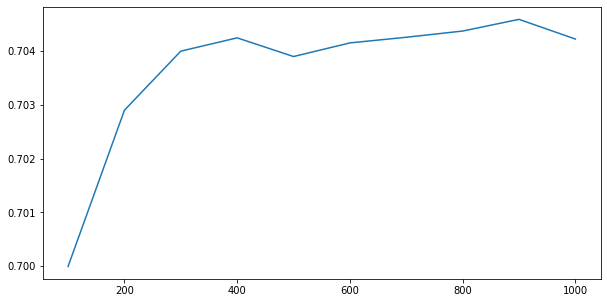

In [24]:
def test_estimators():
    n_est = np.arange(100, 1001, 100)
    results = pd.DataFrame(columns=["n", "rmse", "r2"])
    for n in n_est:
        #print(f"Testing with {n} estimators")
        model = RandomForestRegressor(n_estimators=n, oob_score=True, random_state=123)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        mse = metrics.mean_squared_error(y_test, y_pred)
        r2 = model.score(x_test, y_test)
        results.loc[len(results)] = [n, np.sqrt(mse), r2]
    return results
        
results = test_estimators()
plt.plot(results.n, results.r2)
plt.show()

Sembra che il numero di alberi usati nella foresta sia poco influente sul valore di $R^2$, comunque 300 mi sembra la scelta migliore. 
Possiamo anche controllare come si comporta il RMSE al variare di questo parametro.

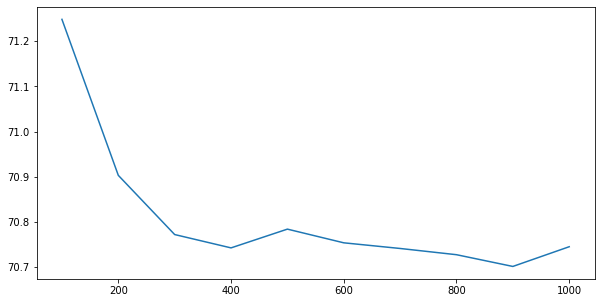

In [25]:
plt.plot(results.n, results.rmse)
plt.show()

Anche per quanto riguarda questo aspetto sembra che 300 sia la scelta migliore.

Un altro iperparametro che può valer la pena testare è sicuramente max_depth, che stabilisce la profondità massima degli alberi che comporranno la foresta. Definiamo una soluzione analoga alla precedente che se ne occupi.

Testing with max depth value set to 10
Testing with max depth value set to 20
Testing with max depth value set to 30
Testing with max depth value set to 40
Testing with max depth value set to 50


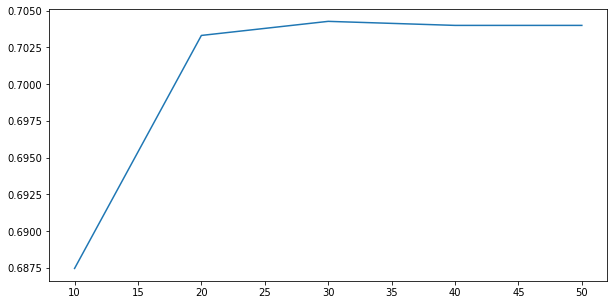

In [30]:
def test_depth():
    depths = np.arange(10, 51, 10)
    results = pd.DataFrame(columns=["depth", "rmse", "r2"])
    for depth in depths:
        #print(f"Testing with max depth value set to {depth}")
        model = RandomForestRegressor(n_estimators=300, max_depth=depth, oob_score=True, random_state=123)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        mse = metrics.mean_squared_error(y_test, y_pred)
        r2 = model.score(x_test, y_test)
        results.loc[len(results)] = [depth, np.sqrt(mse), r2]
    return results

results = test_depth()
plt.plot(results.depth, results.r2)
plt.show()

Sembra che anche questo parametro abbia relativamente poca influenza sulle prestazioni del modello, comunque 20 sembra essere la scelta migliore.

In [31]:
#TODO finire testing iperparametri/possibili miglioramenti
#- aggregazione per ora anzichè per giorno
 #   - Test potential difference between 'h' and 'H' as grouping unit
#- introduzione ulteriori variabili